# Библиотеки и модули:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, median_absolute_error
from xgboost import XGBRegressor 

import statsmodels.formula.api as smf            # статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

from keras import layers, losses, optimizers, metrics, models, activations
import keras

from os import listdir

# Функции:

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
from sklearn.model_selection import TimeSeriesSplit
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False, scale=1.96, tscv = TimeSeriesSplit(n_splits=5)):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [5]:
def plotCoefficients(model, X_train):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [6]:
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [7]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [8]:
def plotSARIMA(series, model, n_steps, s, d, is_print = True):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error =  metrics.mae(data['actual'][s+d:].values, data['arima_model'][s+d:].values)

    if (is_print):
        plt.figure(figsize=(15, 7))
        plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
        plt.plot(forecast, color='r', label="model")
        plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
        plt.plot(data.actual, label="actual")
        plt.legend()
        plt.grid(True);
        plt.show()
    return forecast, error

# Реализация:

Для достижения поставленной задачи рассмотрим данные полученные со сбербанка - моя история доходов и расходов за год  

In [9]:
PATH_DATA = "./data/"
CASH_START_MONTH = 2144

In [10]:
xlsx_file = listdir(PATH_DATA)
for i in range(len(xlsx_file)):
    xlsx_file[i] = PATH_DATA + xlsx_file[i]

In [11]:
DATA_XLSX_INCOME = []
DATA_XLSX_OUTCOME = []
for fil in xlsx_file:
    if fil.find("income")>-1:
        DATA_XLSX_INCOME.append(pd.read_excel(fil, index_col=0))
    if fil.find("outcome")>-1:
        DATA_XLSX_OUTCOME.append(pd.read_excel(fil, index_col=0))

In [12]:
for i in range(len(DATA_XLSX_OUTCOME)):
    print(i, "   ", DATA_XLSX_OUTCOME[i].columns, "\n")

0     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', 'Описание', 'Состояние',
       'Номер счета/карты списания'],
      dtype='object') 

1     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', 'Описание', 'Состояние',
       'Номер счета/карты списания'],
      dtype='object') 

2     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', 'Описание', 'Состояние',
       'Номер счета/карты списания'],
      dtype='object') 

3     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', 'Описание', 'Состояние',
       'Номер счета/карты списания'],
      dtype='object') 

4     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', 'Описание', 'Состояние',
       'Номер счета/карты списания'],
      dtype='object') 

5     Index(['Дата', 'Тип операции', 'Категория', 'Сумма', 'Валюта',
       'Сумма в рублях', '

In [13]:
dataIn = DATA_XLSX_INCOME[0]
for i in range(1,len(DATA_XLSX_INCOME)):
    dataIn = dataIn.append(DATA_XLSX_INCOME[i])

In [14]:
dataOut = DATA_XLSX_OUTCOME[0]
for i in range(1,len(DATA_XLSX_OUTCOME)):
    dataOut = dataOut.append(DATA_XLSX_OUTCOME[i])

In [15]:
def preproces_data(data_in, drop_list):
    data = data_in.copy()

    data = data.drop(drop_list, axis=1)

    def temp_fun(x): 
        alf_month = [
            "января",
            "февраля",
            "марта",
            "апреля",
            "мая",
            "июня",
            "июля",
            "августа",
            "сентября",
            "октября",
            "ноября",
            "декабря",
        ]
        x = x.replace(x[x.find(","):], "")
        day = x[:x.find(" ")]
        x = x.replace(x[:x.find(" ")+1], "", 1)
        for i in range(len(alf_month)):
            if alf_month[i] in x:
                t = ""
                if i + 1 < 10:
                    t = "0"
                x = x.replace(alf_month[i], t + str(i+1))
        x = x[x.find(" "):] + "-" + x[:x.find(" ")] + "-" + day
        x = np.datetime64(x)
        return x

    data["Дата"] = data["Дата"].map(temp_fun)
    data = data.groupby("Дата").sum()
    data = data.sort_index()
    return data

In [16]:
data = preproces_data(dataIn, [
    "Тип операции", 
    "Категория",
    "Валюта",
    "Сумма",
    "Описание",
    "Состояние",
    "Номер счета/карты зачисления"])

data_temp = preproces_data(dataOut, [
    "Тип операции", 
    "Категория",
    "Валюта",
    "Сумма",
    "Описание",
    "Состояние",
    "Номер счета/карты списания"
])

data = data.rename(columns = {
    "Сумма в рублях": "Доход"
})
data_temp = data_temp.rename(columns = {
    "Сумма в рублях": "Расход"
})

max_date = data.index[-1] if data.index[-1] >= data_temp.index[-1] else data_temp.index[-1]
min_date = data.index[0] if data.index[0] <= data_temp.index[0] else data_temp.index[0]
date_list = pd.date_range(min_date, max_date, freq="D")
data_res = pd.DataFrame(index = date_list, columns = ["Доход", "Расход"])
data_res.index.name = "Дата"
data_res["Расход"] = 0
data_res["Доход"] = 0
list_t = data.index
data_res["Доход"].loc[list_t] = data["Доход"].loc[list_t]
list_t = data_temp.index
data_res["Расход"].loc[list_t] = data_temp["Расход"].loc[list_t]
data = data_res
data["Разница"] = 0
data["Разница"] = data["Доход"] - data["Расход"]

In [17]:
data

Доход  Расход  Разница
Дата                              
2022-05-01      0    1197    -1197
2022-05-02      0     906     -906
2022-05-03      0       0        0
2022-05-04      0     806     -806
2022-05-05      0       0        0
...           ...     ...      ...
2023-04-15      4       0        4
2023-04-16      0     350     -350
2023-04-17   2000    4764    -2764
2023-04-18      0     400     -400
2023-04-19      0     627     -627

[354 rows x 3 columns]

В результате получили данные в виде временного ряда, размерностью которого являются дни в году

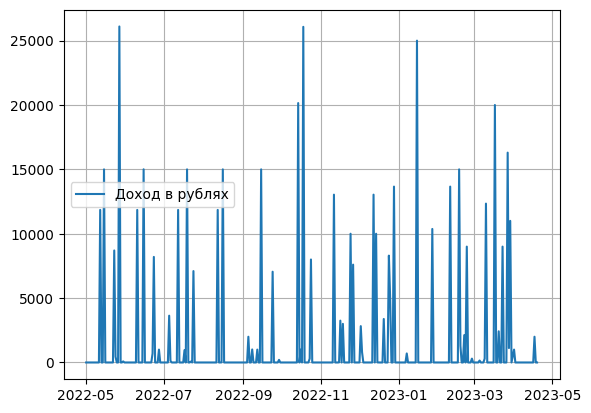

In [18]:
# plt.plot(data.index, data["Прибыль"], label = "Прибыль")
plt.plot(data.index, data["Доход"], label = "Доход в рублях")
plt.legend()
plt.grid()
plt.show()

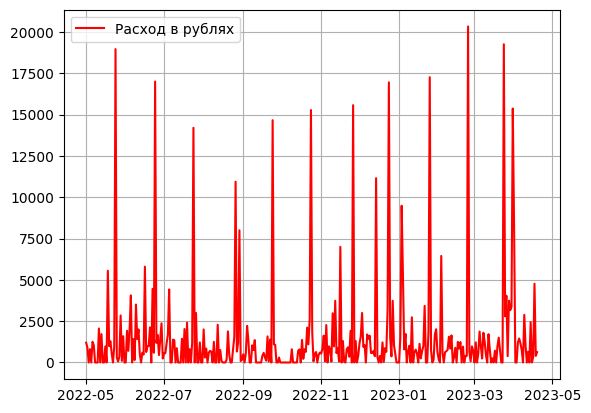

In [19]:
plt.plot(data.index, data["Расход"], label = "Расход в рублях", color = "red")
plt.legend()
plt.grid()
plt.show()

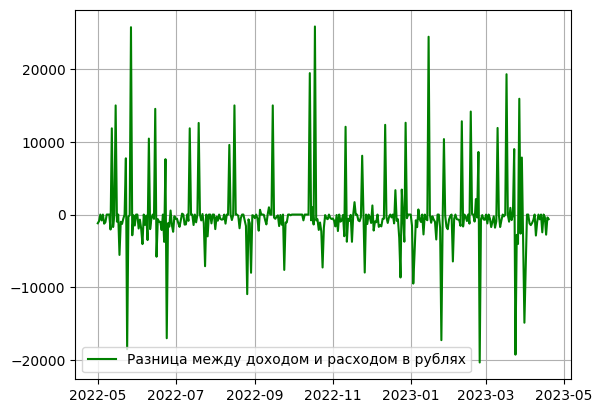

In [20]:
plt.plot(data.index, data["Доход"] - data["Расход"], label = "Разница между доходом и расходом в рублях", color="green")
plt.legend()
plt.grid()
plt.show()

In [21]:
data["Доход"].sum()

493822

In [22]:
data["Доход"].median()

0.0

In [23]:
data["Доход"].std()

4216.956645251379

In [24]:
data["Расход"].sum()

529890

In [25]:
data["Расход"].median()

636.0

In [26]:
data["Расход"].std()

3154.469648519713

In [27]:
data["Разница"].sum()

-36068

In [28]:
data["Разница"].median()

-530.0

In [29]:
data["Разница"].std()

5070.569557908366

Проанализировав выше полученные данные можно прийти к выводу что данный ряд является крайне не стабыльным, однако на графиках виднеется некоторя сезоность и тренда как такового не наблюдается на всем промежутке, однако данное утверждение может быть поспешным, поэтому далее будет расмотрен данный ряд более подробно.

# Предсказание на имеющихся данных и алгоритмы ML (LinearRegression, XGBRegressor, SARIMAX)

По имеющимся предположениям попробуем посметреть и проанализировать ряд при помощи нескольких алгоритмов машинного обучения а именно: LinearRegression, XGBRegressor, SARIMA.

In [30]:
MODELS = [[LinearRegression(), "LinearRegression"], [XGBRegressor(), "XGBRegressor"]]
NAME = "Разница"
lag_razm = 7
lag_len = 31

----------------------------------------------------------------------------------------------------
model is LinearRegression
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


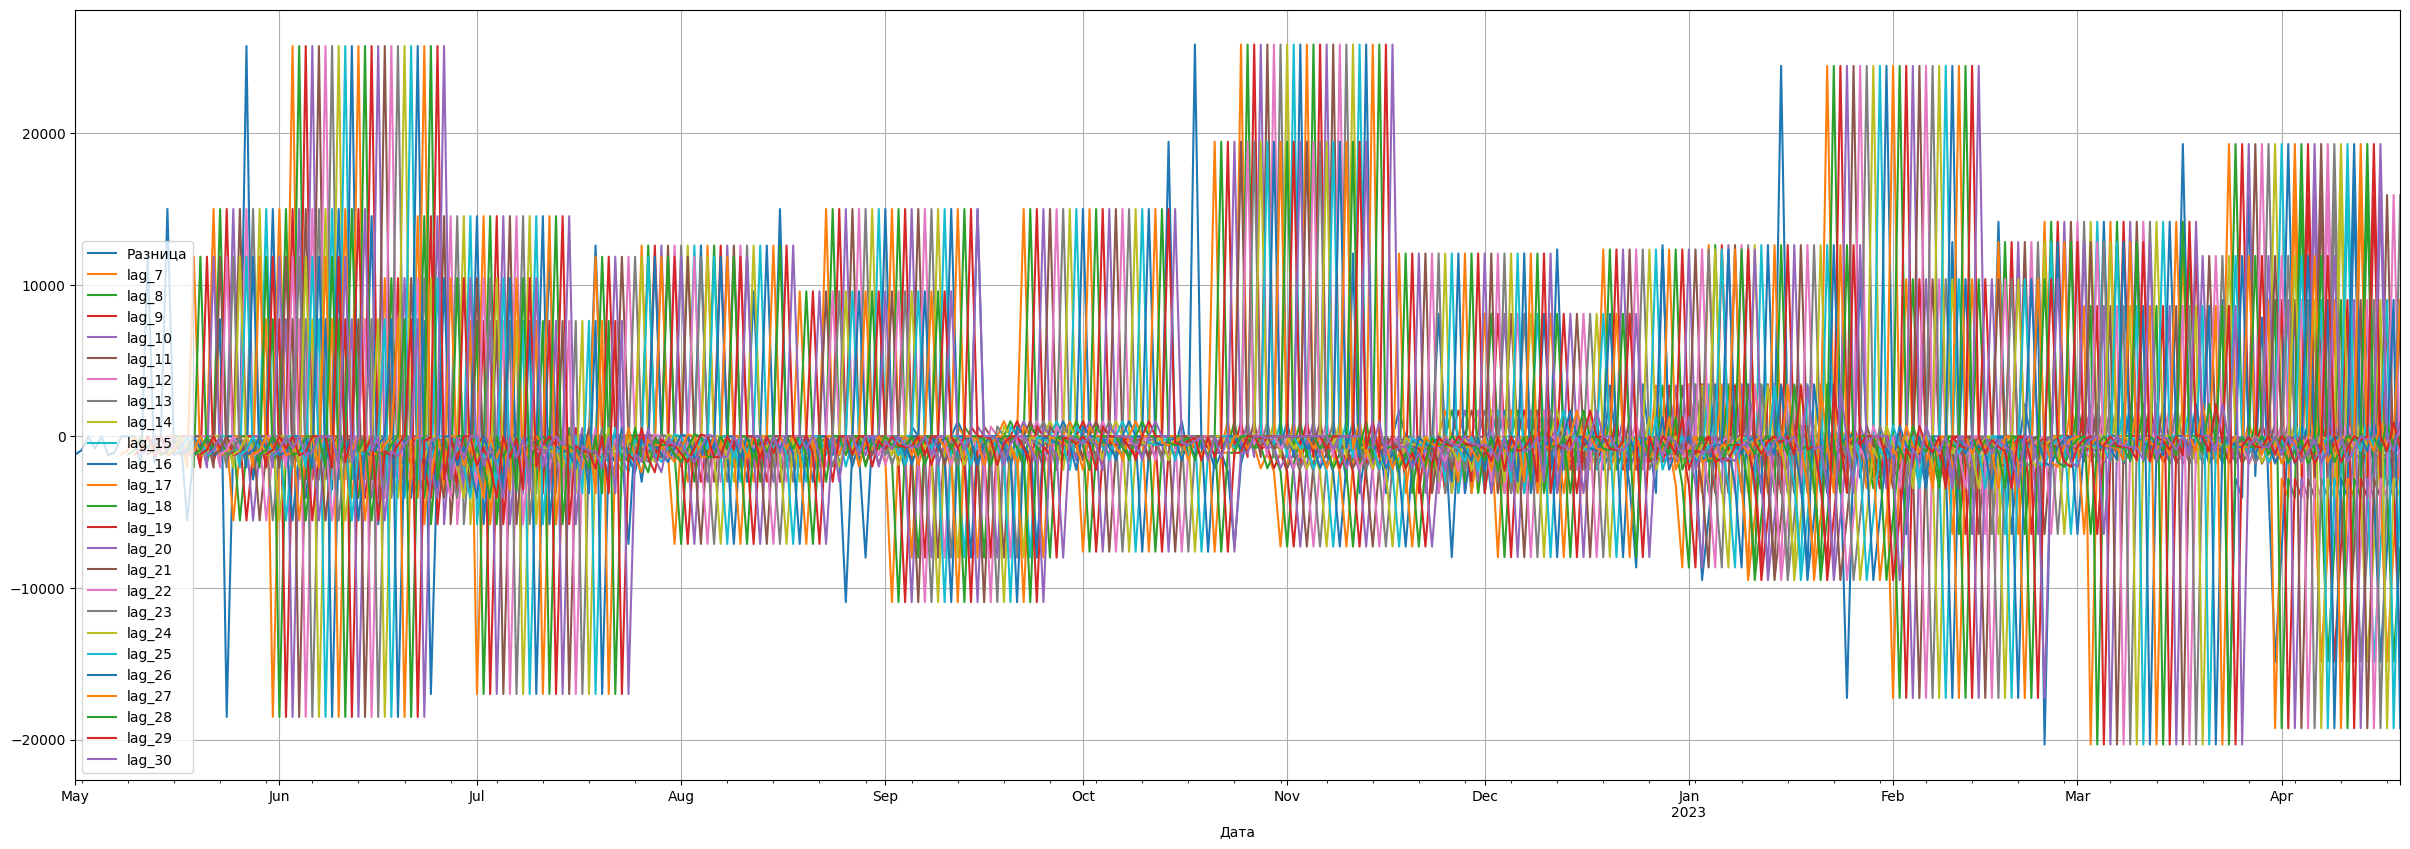

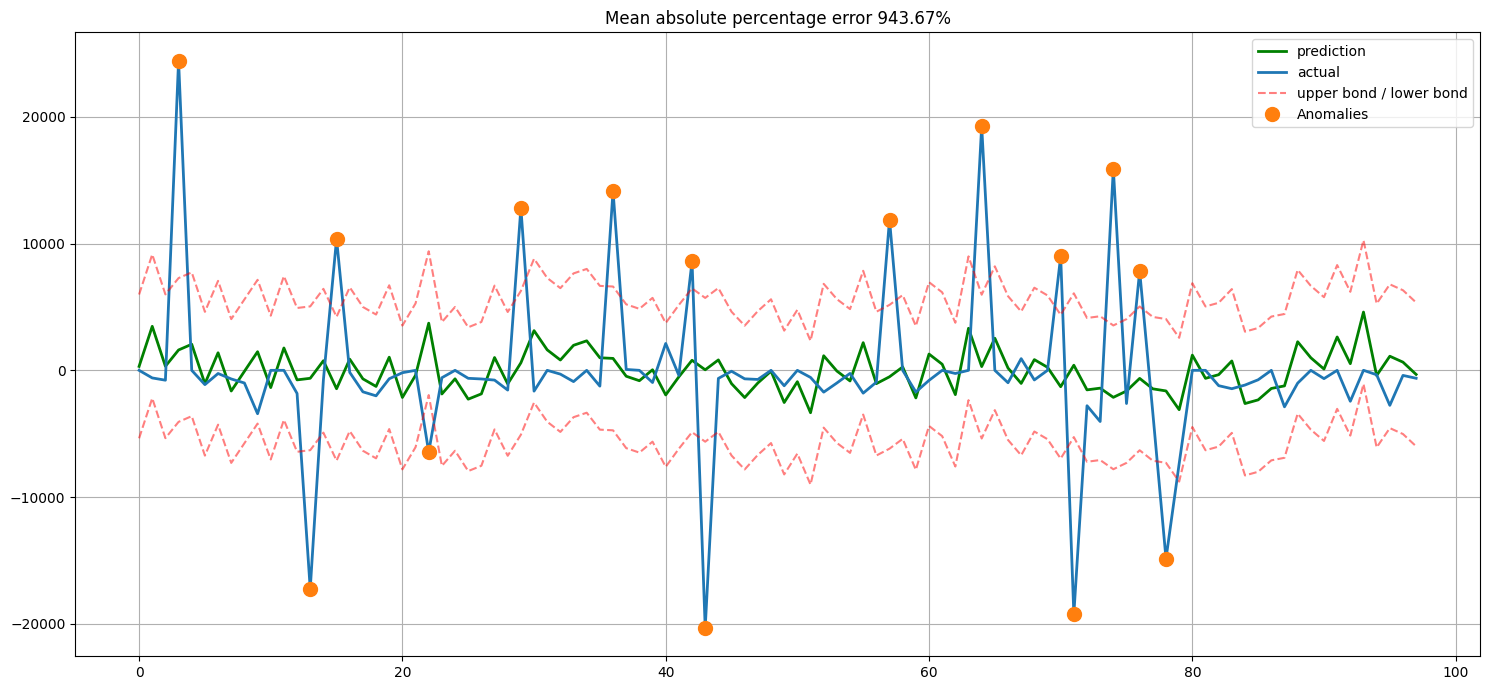

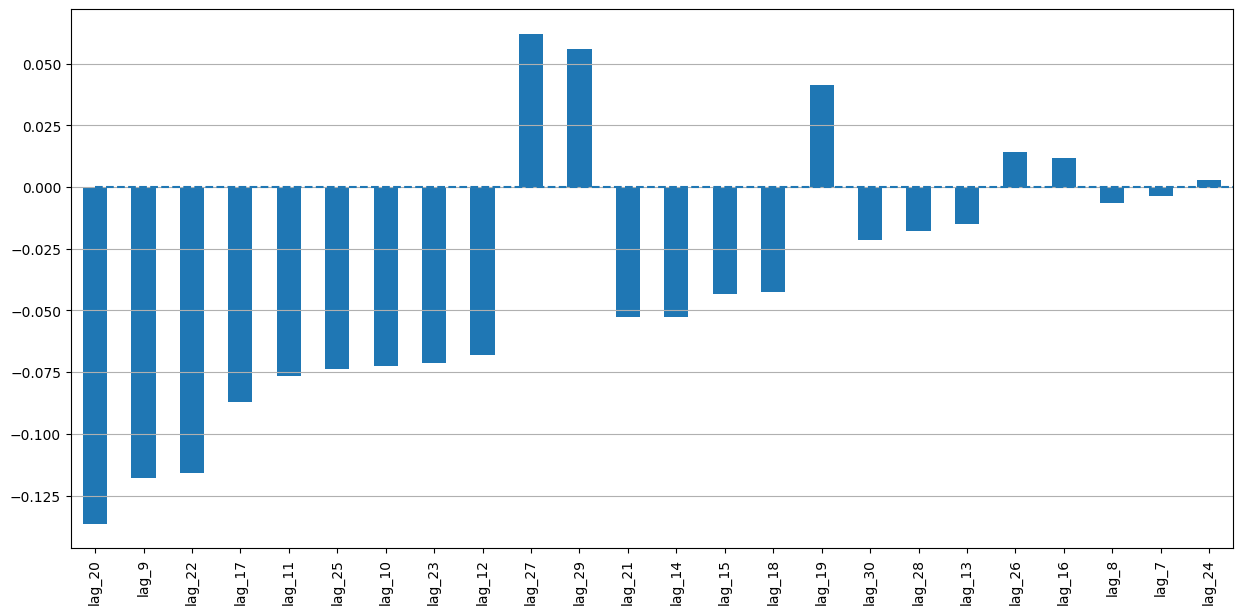

----------------------------------------------------------------------------------------------------
model is XGBRegressor
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


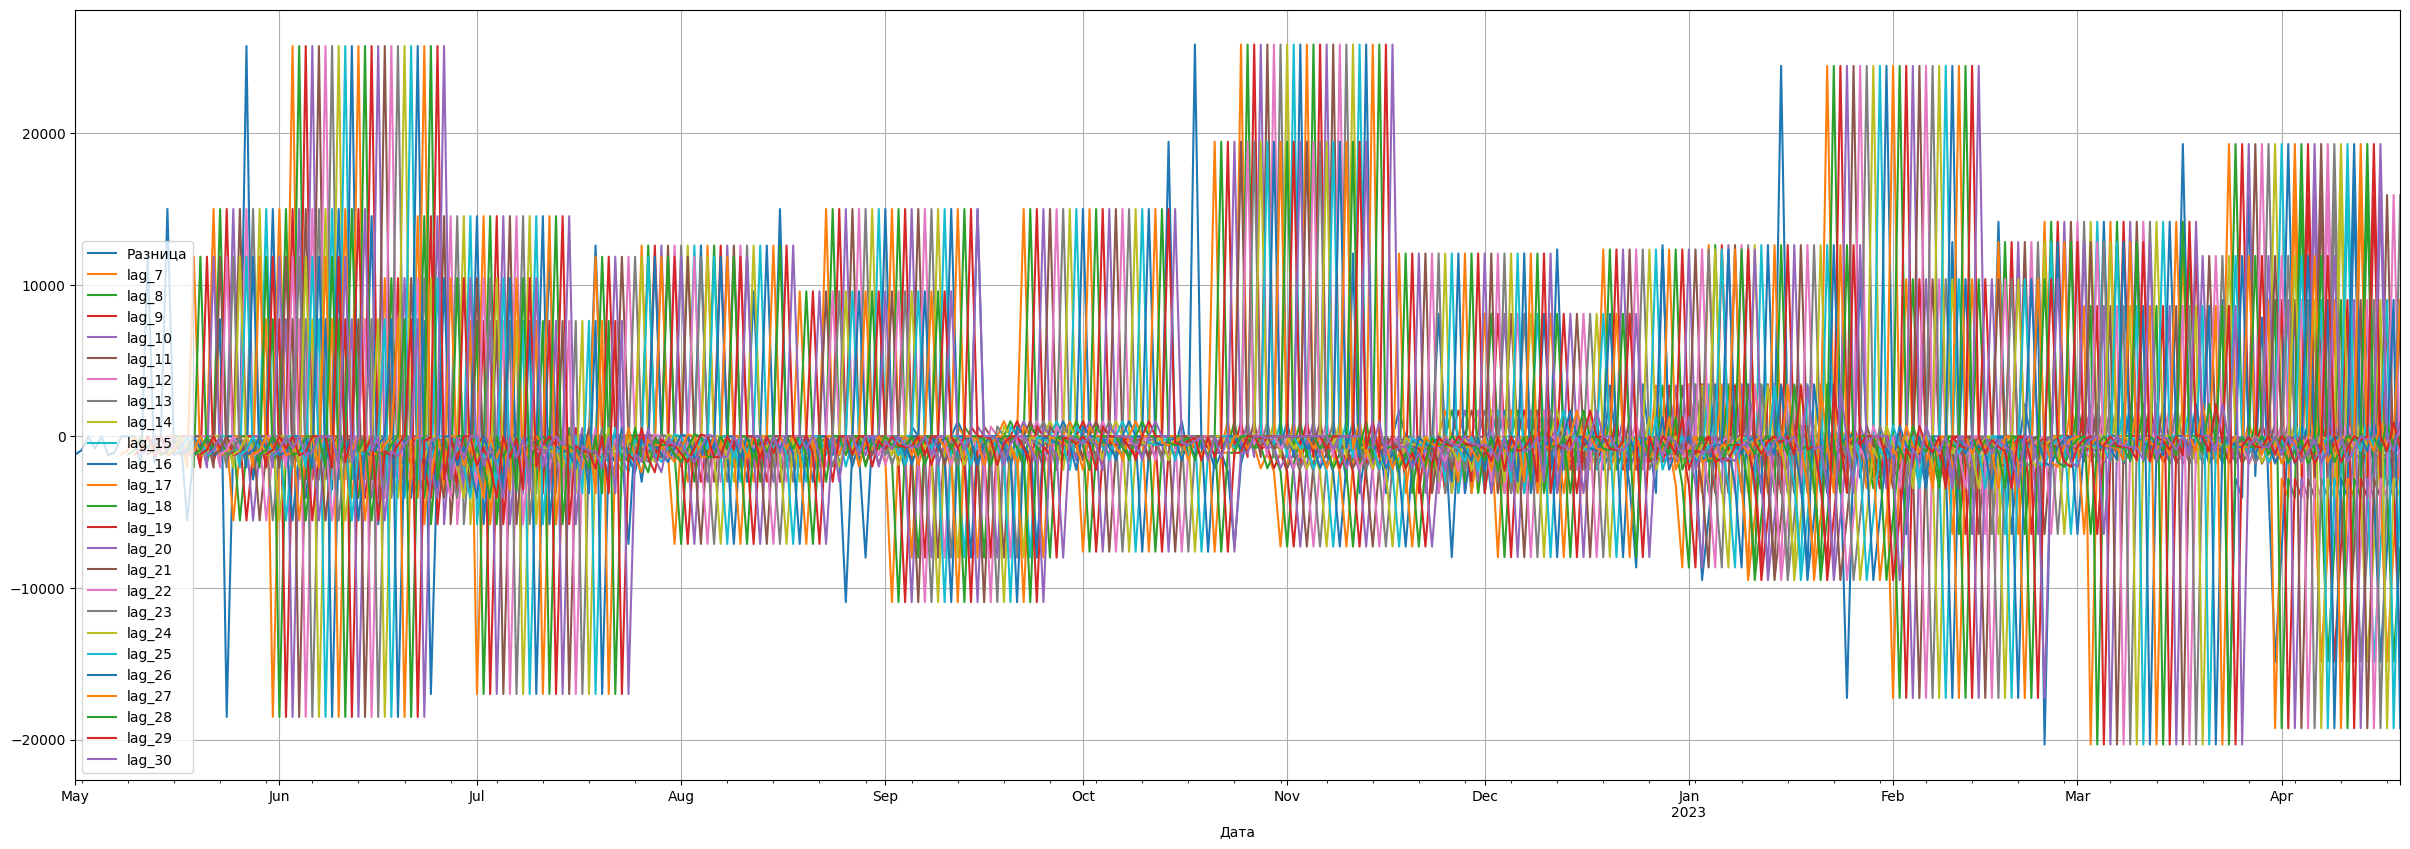

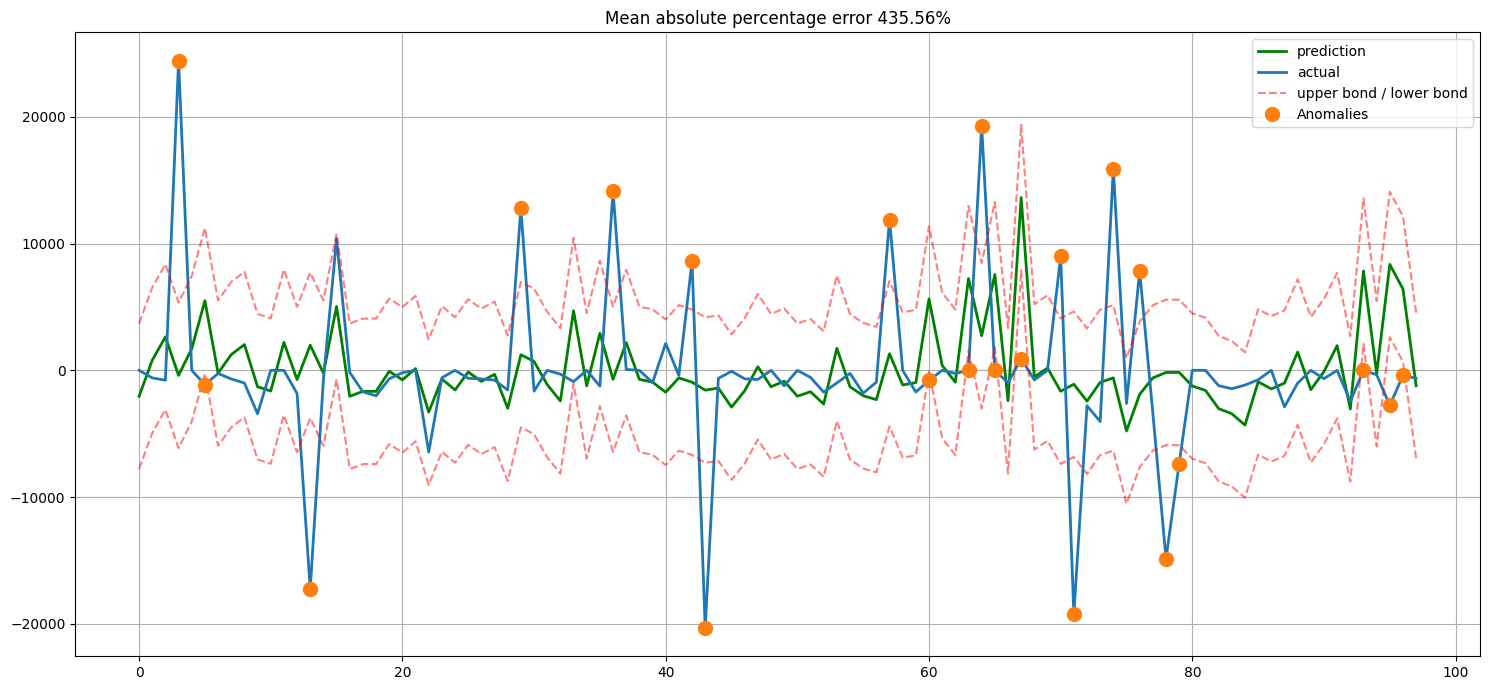

In [31]:
for model in MODELS:
    print("-"*100)
    print("model is " + model[1])
    print("-"*100)
    print("*"*100)
    print("analysis of ",NAME)
    print("*"*100)

    data_temp = pd.DataFrame(data[NAME])

    for i in range(lag_razm, lag_len):
        data_temp["lag_{}".format(i)] = data_temp[NAME].shift(i)

    axi = data_temp.plot(figsize = (30,10))
    if (lag_len-lag_razm>30):
        axi.legend([])
    axi.grid(True)

    Y = data_temp.dropna()[NAME]
    X = data_temp.drop([NAME],axis=1).dropna()

    x_train, x_test, y_train, y_test = timeseries_train_test_split(X, Y, 0.30)

    model[0].fit(x_train,y_train)

    plotModelResults(model[0], x_train, x_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
    if(model[1]!="XGBRegressor"):
        plotCoefficients(model[0], x_train)
    plt.show()

Как видно из графиков такие данные являются крайне не валидными, так как наблюдается много аномалий в виде незапланированных трат или дохода в виде подарка на день рождение. Однако можно сделать вывод что модель XGBRegressor предсказывает более точно нежели LinearRegression.

### С использованием StandartScaler:

Попробуем обощить данные при помощи инструмента StandartScaler, поскольку имеется большой разрыв между значениями в данных.

----------------------------------------------------------------------------------------------------
model is LinearRegression
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


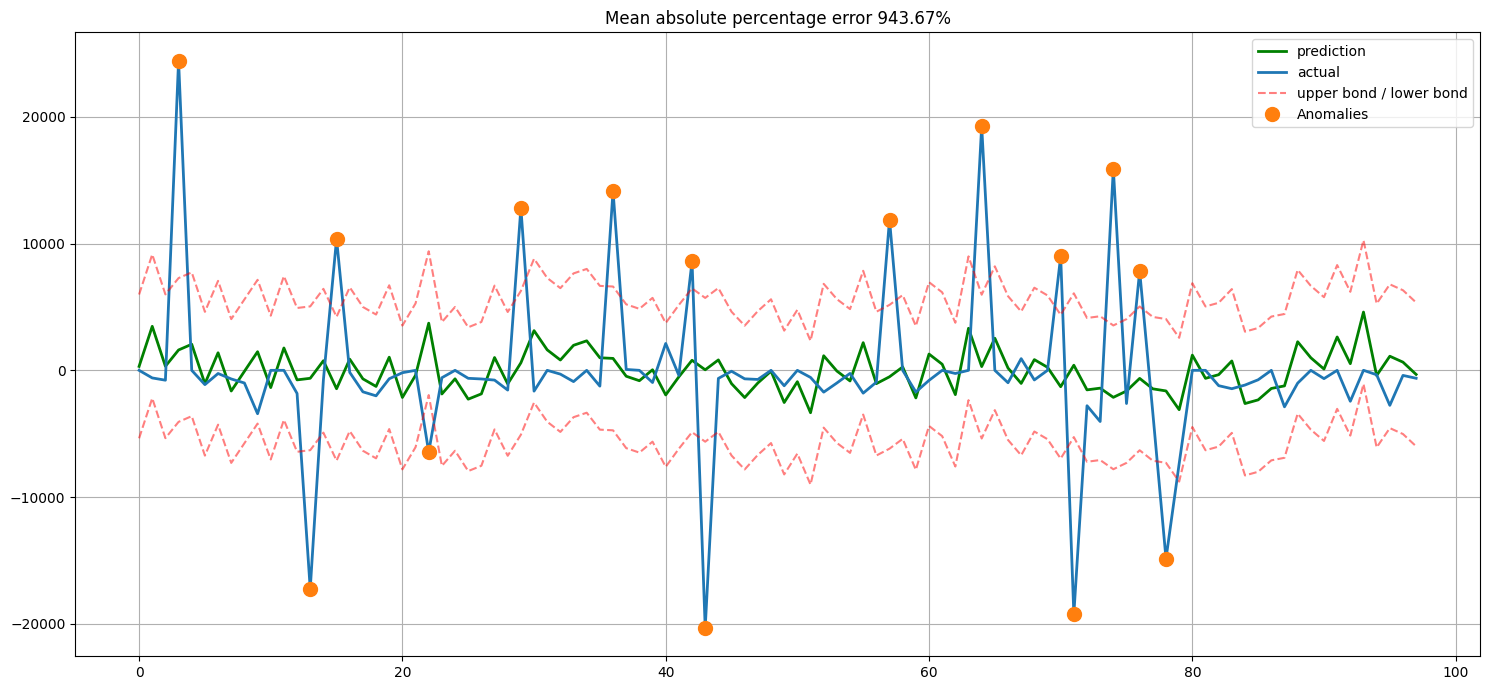

----------------------------------------------------------------------------------------------------
model is XGBRegressor
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


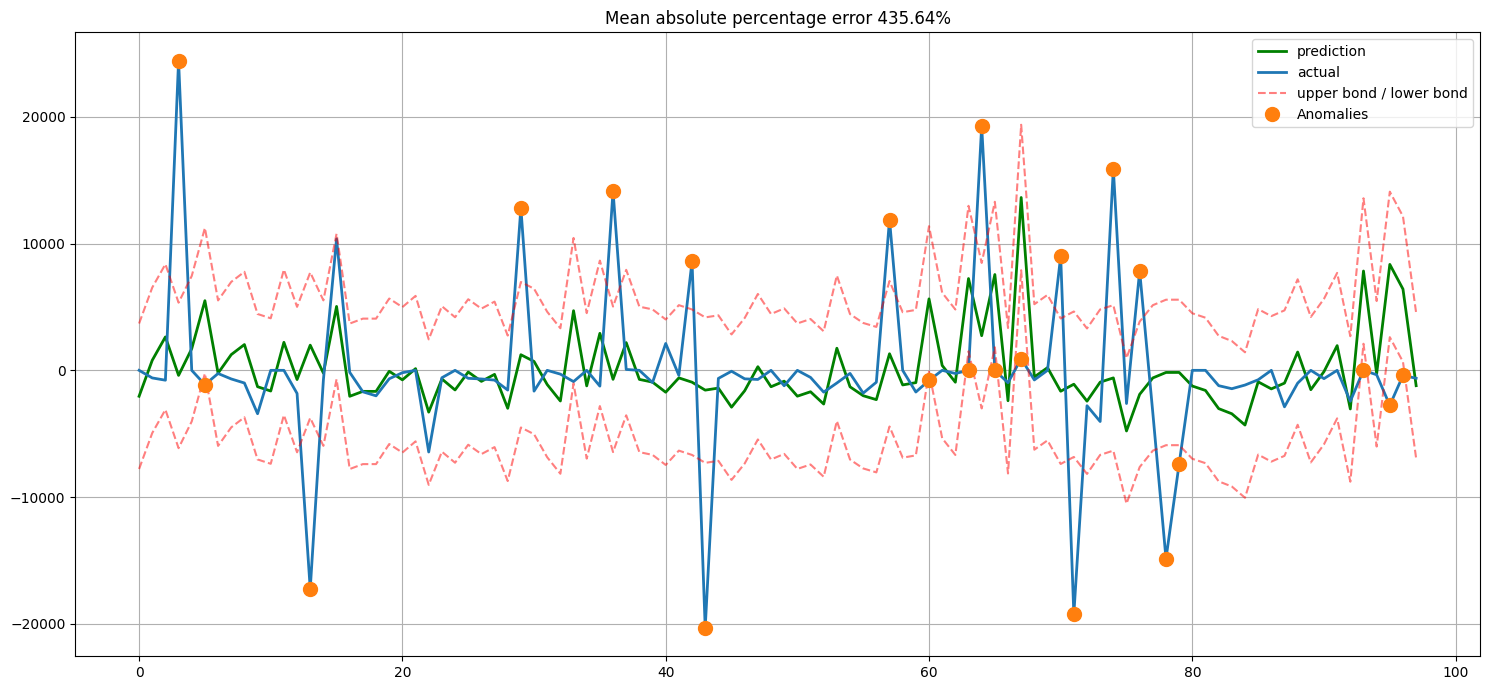

In [32]:
scaler = StandardScaler()
for model in MODELS:
    print("-"*100)
    print("model is " + model[1])
    print("-"*100)
    print("*"*100)
    print("analysis of ",NAME)
    print("*"*100)

    data_temp = pd.DataFrame(data[NAME])

    for i in range(lag_razm, lag_len):
        data_temp["lag_{}".format(i)] = data_temp[NAME].shift(i)

    Y = data_temp.dropna()[NAME]
    X = data_temp.drop([NAME],axis=1).dropna()

    x_train, x_test, y_train, y_test = timeseries_train_test_split(X, Y, 0.30)
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    model[0].fit(x_train_scaled,y_train)

    plotModelResults(model[0], x_train_scaled, x_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)
    plt.show()

В результате обобщения данных получили следующий результат, точность предсказания снизилась на сотый процент, то есть модели стали предсказывать чуть хуже, чем было, что можно наблюдать по лучшей модели XGBRegressor.

### Уберем аномалии:

Попробуем убрать аномалии из данных, а именно заменить их на среднее значение в колонке, в результате получается что избавились от части данных которые могут быть важны, и поэтому уже идет относительный прогноз.

In [33]:
data_not_anomalies = data.copy()
data_not_anomalies.describe()

Доход        Расход       Разница
count    354.000000    354.000000    354.000000
mean    1394.977401   1496.864407   -101.887006
std     4216.956645   3154.469649   5070.569558
min        0.000000      0.000000 -20331.000000
25%        0.000000      0.000000  -1211.500000
50%        0.000000    636.000000   -530.000000
75%        0.000000   1378.500000      0.000000
max    26100.000000  20331.000000  25851.000000

In [34]:
label_name = "Доход"
for name in list(data_not_anomalies.columns):
    mean_val = data_not_anomalies[name].mean()
    std_val = data_not_anomalies[name].std()
    summ_std_mean = mean_val + std_val
    subt_std_mean = mean_val - std_val
    data_not_anomalies[name][(data_not_anomalies[name]>summ_std_mean) | (data_not_anomalies[name]<subt_std_mean)] = mean_val
data_not_anomalies.describe()

D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Доход       Расход      Разница
count   354.000000   354.000000   354.000000
mean    254.695570   833.810782  -615.165789
std     651.958436   904.402631   953.874428
min       0.000000     0.000000 -4060.000000
25%       0.000000     0.000000 -1000.000000
50%       0.000000   636.000000  -297.500000
75%       0.000000  1378.500000     0.000000
max    5000.000000  4455.000000  3435.000000

----------------------------------------------------------------------------------------------------
model is LinearRegression
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


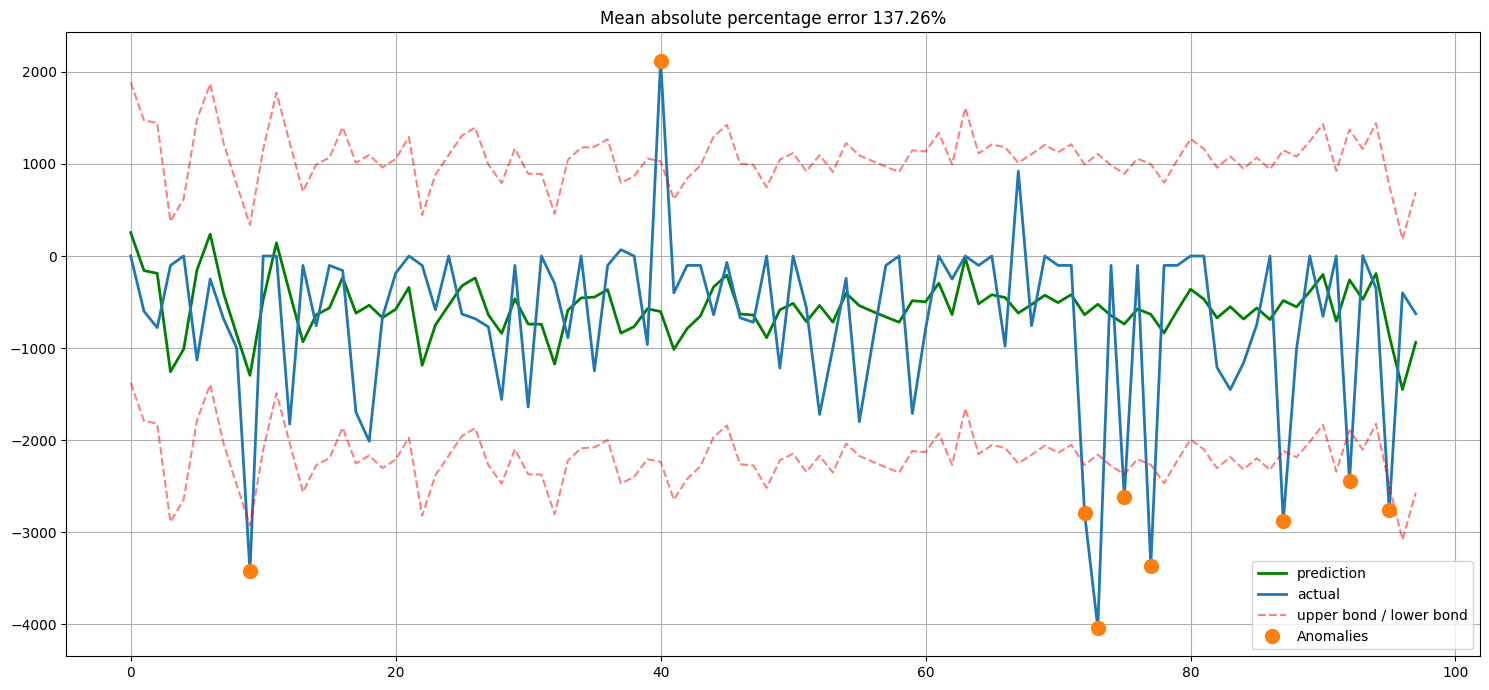

----------------------------------------------------------------------------------------------------
model is XGBRegressor
----------------------------------------------------------------------------------------------------
****************************************************************************************************
analysis of  Разница
****************************************************************************************************


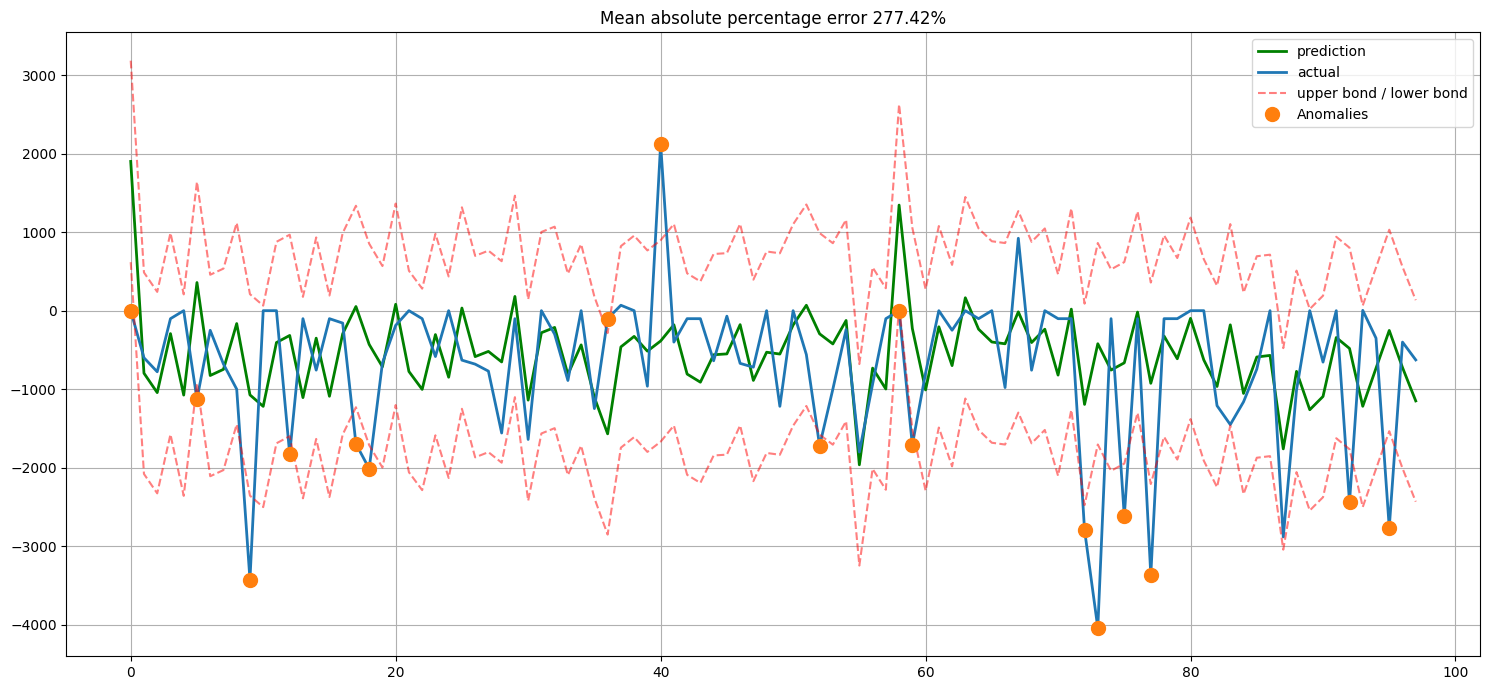

In [35]:
scaler = StandardScaler()
for model in MODELS:
    print("-"*100)
    print("model is " + model[1])
    print("-"*100)
    print("*"*100)
    print("analysis of ",NAME)
    print("*"*100)

    data_temp = pd.DataFrame(data_not_anomalies[NAME])

    for i in range(lag_razm, lag_len):
        data_temp["lag_{}".format(i)] = data_temp[NAME].shift(i)

    Y = data_temp.dropna()[NAME]
    X = data_temp.drop([NAME],axis=1).dropna()

    x_train, x_test, y_train, y_test = timeseries_train_test_split(X, Y, 0.30)
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    model[0].fit(x_train_scaled,y_train)

    plotModelResults(model[0], x_train_scaled, x_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)
    plt.show()

В результате отсеивания аномалий пришли к тому что модели стали предсказывать чуть лучше, но все равно ошибка держится за пределами допустимого,да и аномалий прибавилось.

### Исследование взаимосвязей между данными

Рассмотрим примерно взаимоотношение между данными при помощи матрицы корреляции.

matrix corel value of column is Разница


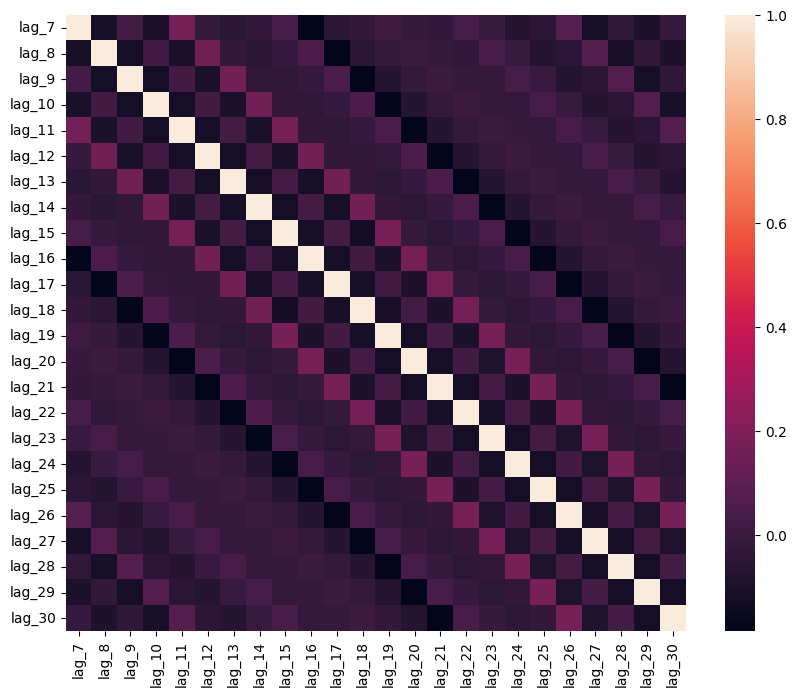

In [36]:
data_temp_corr = data.copy()
            
data_temp = pd.DataFrame(data_temp_corr[NAME])

for i in range(lag_razm, lag_len):
    data_temp["lag_{}".format(i)] = data_temp[NAME].shift(i)

Y = data_temp.dropna()[NAME]
X = data_temp.drop([NAME],axis=1).dropna()

x_train, x_test, y_train, y_test = timeseries_train_test_split(X, Y, 0.30)
plt.show()
print("matrix corel value of column is " + NAME)
plt.figure(figsize=(10, 8))
sns.heatmap(x_train.corr());
plt.show()

Из отображений матриц видна кореляция для колонки Разница, следовательно дальнейшие рассуждения будут проводится именно по этой колонке.

D:\Programs\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.000000


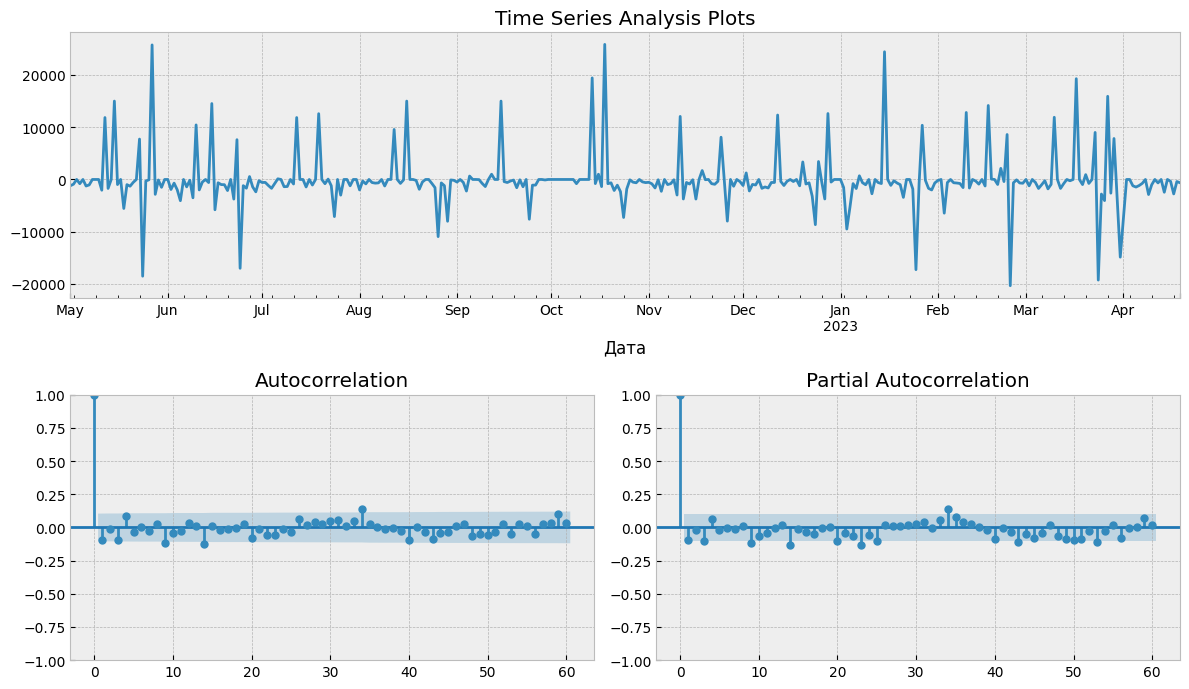

In [37]:
data_temp_samra = data.copy()
data_betw = data_temp_samra["Разница"]
tsplot(data_betw, lags=60)

D:\Programs\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.000000


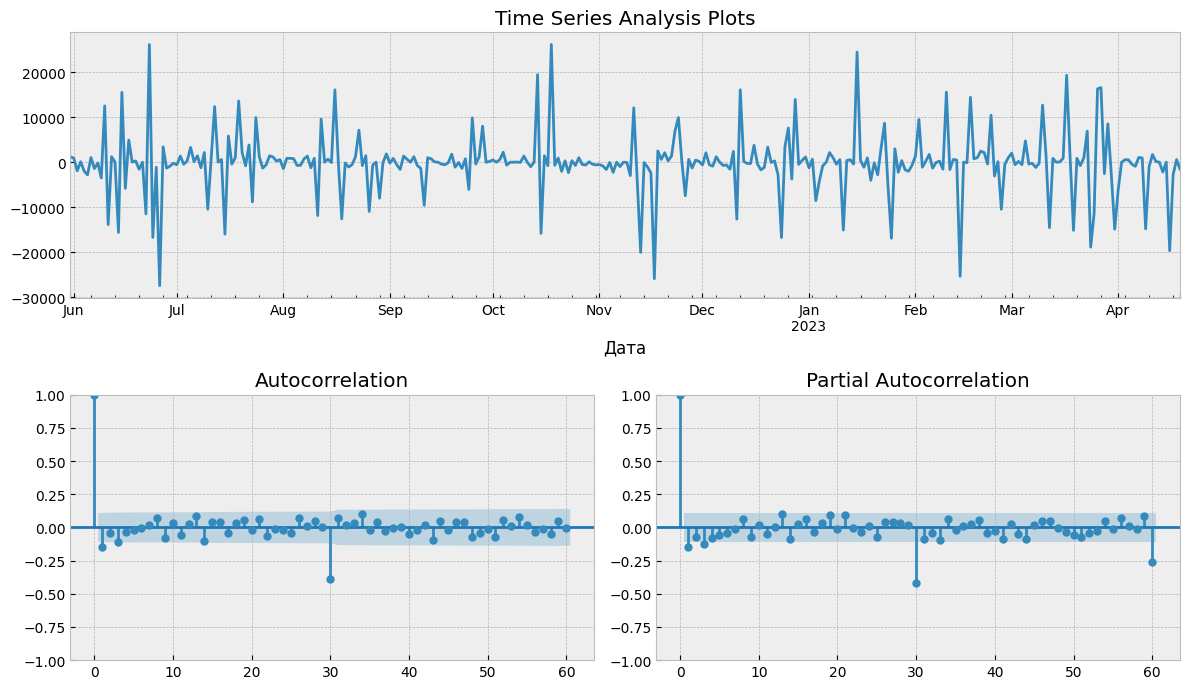

In [38]:
data_dif = data_betw - data_betw.shift(30)
tsplot(data_dif[30:], lags=60)

D:\Programs\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.000000


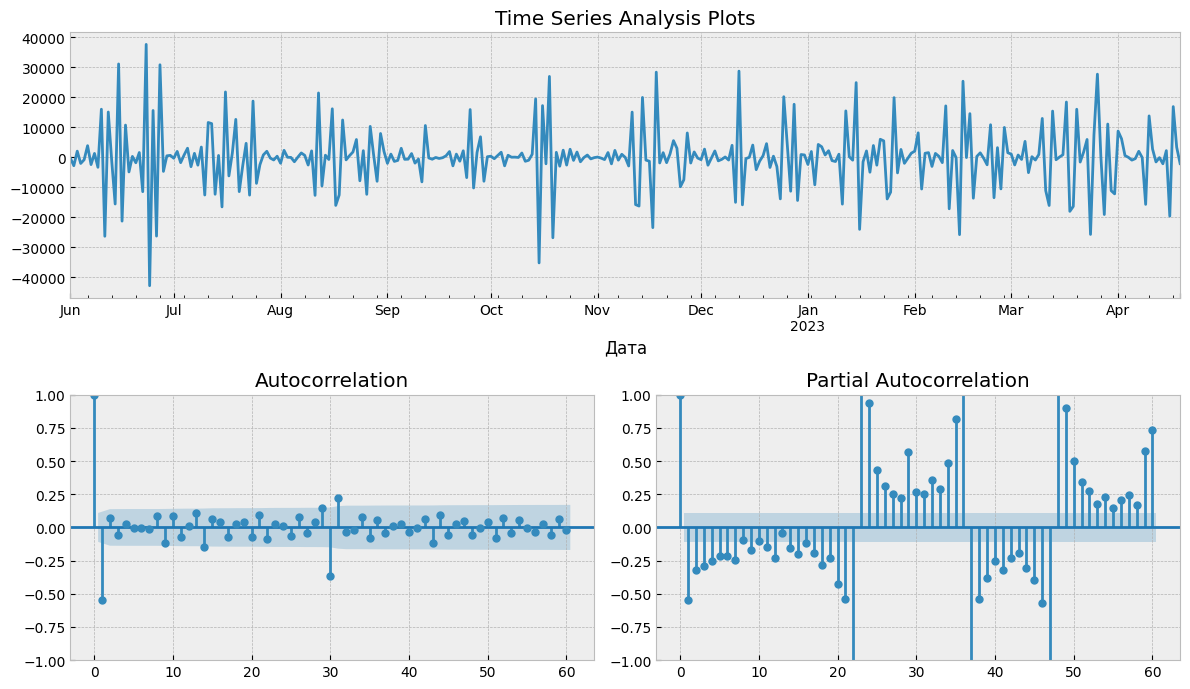

In [39]:
data_dif = data_dif - data_dif.shift(1)
tsplot(data_dif[30+1:], lags=60)

In [40]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(20, 25)
d=1 # тут мы уверены, дифференцировали один раз
qs = range(1, 3)

Ps = range(0, 1)
D=1 # здесь тоже уверены, сезонное дифференцирование было одно
Qs = range(1, 3)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [41]:
optim_model = optimizeSARIMA(data_temp_samra["Разница"], parameters_list, d, D, s)

D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

D:\Programs\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programs\anaconda\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programs\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programs\anaconda\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programs\anaconda\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

In [42]:
optim_model

parameters          aic
0   (20, 1, 0, 1)  6472.063810
1   (22, 1, 0, 1)  6488.540609
2   (24, 2, 0, 1)  6509.646006
3   (24, 2, 0, 2)  6510.653867
4   (23, 1, 0, 1)  6511.004270
5   (21, 2, 0, 1)  6511.885193
6   (23, 1, 0, 2)  6512.309576
7   (22, 2, 0, 1)  6512.380881
8   (23, 2, 0, 1)  6512.468241
9   (24, 1, 0, 1)  6512.634239
10  (22, 1, 0, 2)  6512.872187
11  (21, 2, 0, 2)  6513.057443
12  (23, 2, 0, 2)  6513.472025
13  (22, 2, 0, 2)  6513.576780
14  (24, 1, 0, 2)  6513.934039
15  (21, 1, 0, 1)  6515.296921
16  (20, 2, 0, 1)  6515.562625
17  (20, 1, 0, 2)  6515.856587
18  (21, 1, 0, 2)  6516.710395
19  (20, 2, 0, 2)  6516.905872

In [43]:
p, q, P, Q = optim_model.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(data_temp_samra["Разница"], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

D:\Programs\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programs\anaconda\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                             Разница   No. Observations:                  354
Model:             SARIMAX(20, 1, 1)x(0, 1, 1, 30)   Log Likelihood               -3213.032
Date:                             Tue, 09 May 2023   AIC                           6472.064
Time:                                     14:01:47   BIC                           6558.950
Sample:                                 05-01-2022   HQIC                          6506.748
                                      - 04-19-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1323      0.084     -1.569      0.117      -0.298       0.033
ar.L2         -0.0733      

D:\Programs\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.000000


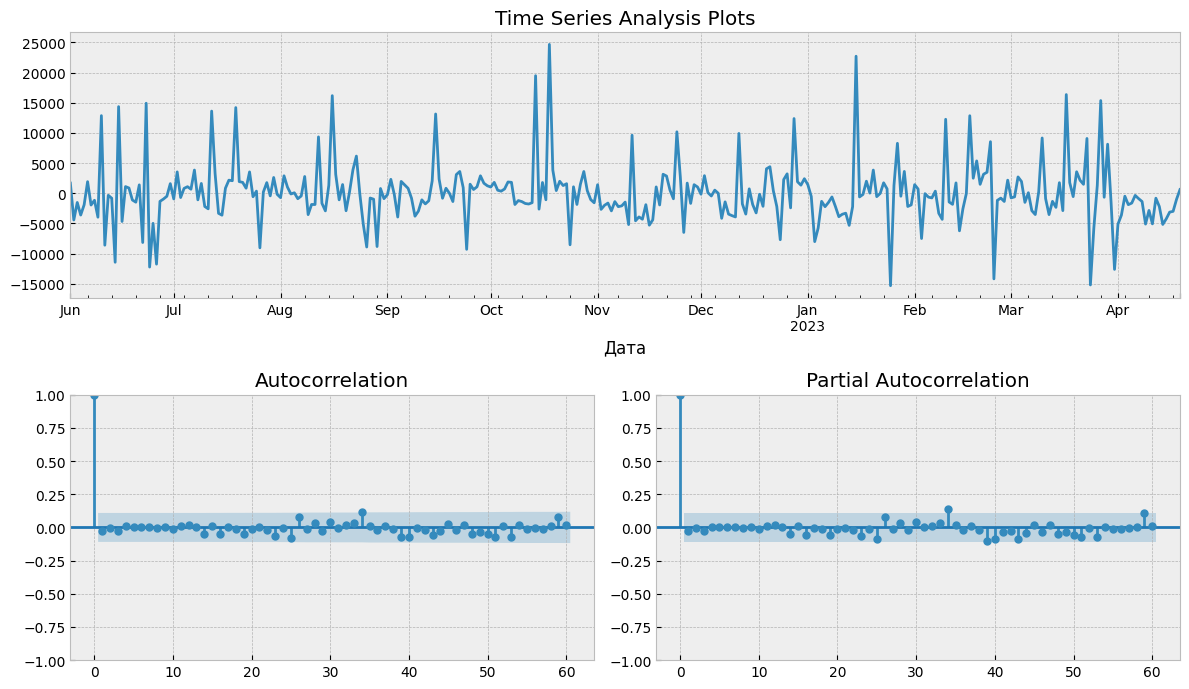

In [44]:
tsplot(best_model.resid[30+1:], lags=60)

D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


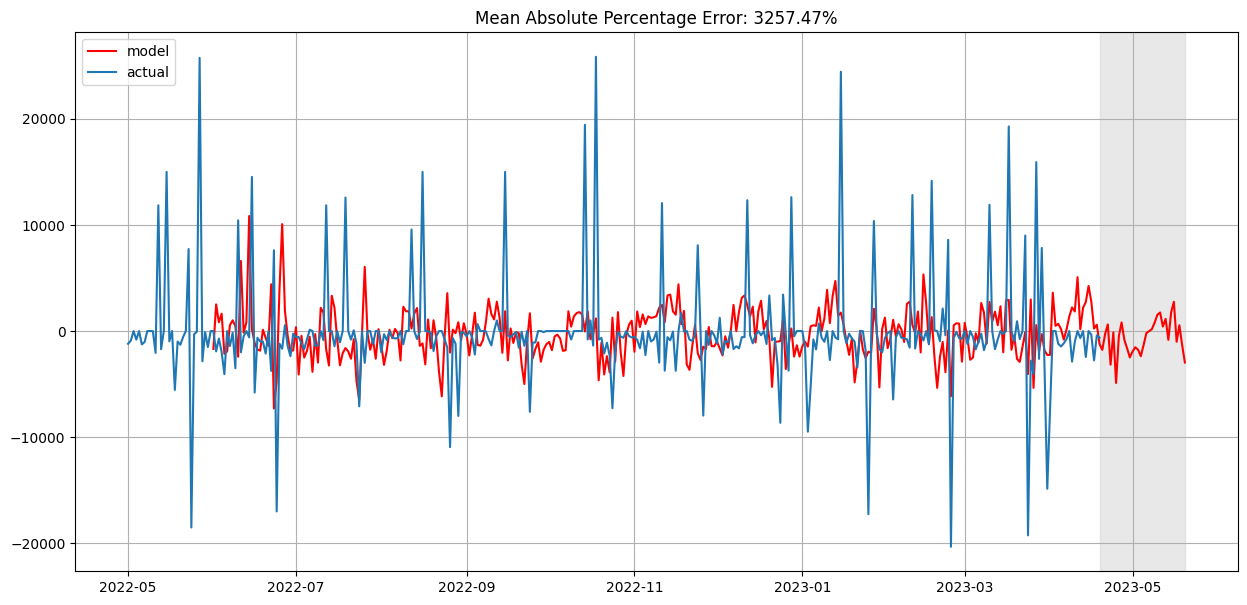

In [45]:
plotSARIMA(pd.DataFrame(data_temp_samra["Разница"]), best_model, 30, s, d);

Как видно модель SARIMA тоже не смогла предсказать сильные всплески, хотя при анализе графиков она смогла приблизиться к оригинальным значениям. 

Из рассмотренных трех моделей получаем следующий вывод, а именно что для предсказания хаотичных значений разницы между доходом и расходом при помощи стационарных моделей (LinearRegression, XGBRegressor, SARIMA) делаются с очень большой погрешностью, поэтому для решения поставленной задачи воспользуемся нейронной сетью с долгосрочной памятью LSTM.

# Нейронная сеть LSTM

Для решения поставленной задачи используем нейронную сеть LSTM - сеть с долгосрочной памятью. Это значит что сеть будет основываться не только на передоваемых в модель значения, но и на предыдущий результат предсказания. Что как раз подходит для реализации предсказания по временному ряду. 

Для реализации модели на основе LSTM, воспользуемся библиотекой keras

In [70]:
N_day = 30 # на сколько дней будет опираться модель
Test_size = 0.10 # процент тестовой выборки от всей выборки

In [71]:
data_inp = data["Разница"].values
scaler = StandardScaler()
data_inp = scaler.fit_transform(data_inp.reshape(-1,1))

In [72]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[(i + look_back)])
    return np.array(dataX), np.array(dataY)

In [73]:
trainX, trainY = create_dataset(data_inp[:int(len(data_inp)*(1-Test_size))], N_day)
testX, testY = create_dataset(data_inp[int(len(data_inp)*(1-Test_size)):], N_day)

In [100]:
model = keras.Sequential([ #42% точности но ряд выдается лучше
    layers.LSTM(128, input_shape=(N_day, 1), return_sequences=True),
    layers.Dropout(0.2),#0.5
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),#0.1
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.6),#0.2
    layers.LSTM(128),
    layers.Dropout(0.4),#0.1
    layers.Dense(1, activation = "linear")
])

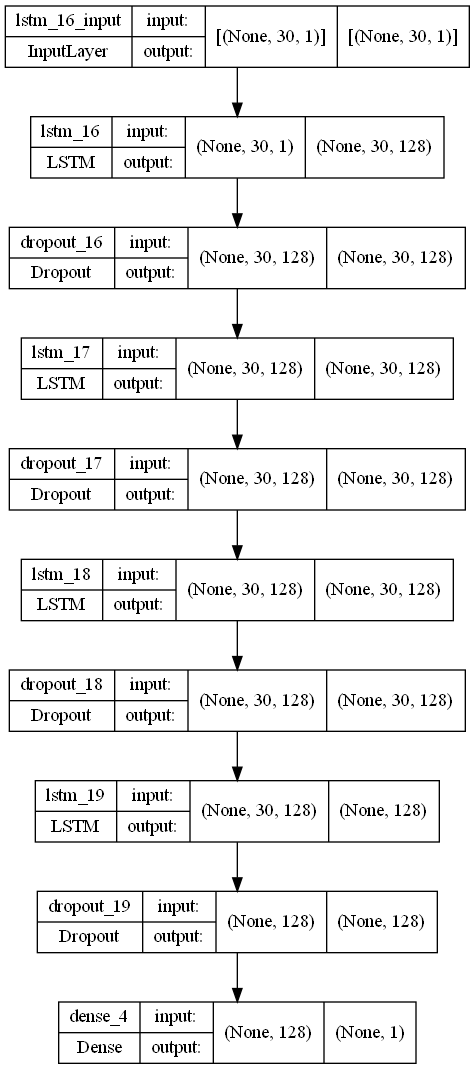

In [101]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [102]:
model.compile(optimizer="adam", loss='mse', metrics=metrics.mae)

In [103]:
history_model = model.fit(
    trainX.reshape(-1,N_day,1),
    trainY,
    epochs=300,
    batch_size=10,
    verbose=1
)

Epoch 1/300
29/29 [==============================] - 10s 120ms/step - loss: 0.8277 - mean_absolute_error: 0.4463
Epoch 2/300
29/29 [==============================] - 3s 113ms/step - loss: 0.8283 - mean_absolute_error: 0.4191
Epoch 3/300
29/29 [==============================] - 3s 109ms/step - loss: 0.8195 - mean_absolute_error: 0.4388
Epoch 4/300
29/29 [==============================] - 3s 113ms/step - loss: 0.8240 - mean_absolute_error: 0.4411
Epoch 5/300
29/29 [==============================] - 3s 118ms/step - loss: 0.8358 - mean_absolute_error: 0.4409
Epoch 6/300
29/29 [==============================] - 3s 115ms/step - loss: 0.8246 - mean_absolute_error: 0.4437
Epoch 7/300
29/29 [==============================] - 3s 110ms/step - loss: 0.8178 - mean_absolute_error: 0.4446
Epoch 8/300
29/29 [==============================] - 3s 111ms/step - loss: 0.8104 - mean_absolute_error: 0.4424
Epoch 9/300
29/29 [==============================] - 3s 115ms/step - loss: 0.8268 - mean_absolute_error

29/29 [==============================] - 4s 126ms/step - loss: 0.6718 - mean_absolute_error: 0.4484
Epoch 74/300
29/29 [==============================] - 3s 116ms/step - loss: 0.6764 - mean_absolute_error: 0.4538
Epoch 75/300
29/29 [==============================] - 3s 111ms/step - loss: 0.6510 - mean_absolute_error: 0.4792
Epoch 76/300
29/29 [==============================] - 3s 110ms/step - loss: 0.6183 - mean_absolute_error: 0.4513
Epoch 77/300
29/29 [==============================] - 3s 115ms/step - loss: 0.6451 - mean_absolute_error: 0.4689
Epoch 78/300
29/29 [==============================] - 3s 106ms/step - loss: 0.5661 - mean_absolute_error: 0.4413
Epoch 79/300
29/29 [==============================] - 3s 112ms/step - loss: 0.6460 - mean_absolute_error: 0.4754
Epoch 80/300
29/29 [==============================] - 3s 107ms/step - loss: 0.6609 - mean_absolute_error: 0.4458
Epoch 81/300
29/29 [==============================] - 3s 110ms/step - loss: 0.6176 - mean_absolute_error: 0.4

29/29 [==============================] - 4s 124ms/step - loss: 0.1960 - mean_absolute_error: 0.2573
Epoch 146/300
29/29 [==============================] - 3s 119ms/step - loss: 0.1953 - mean_absolute_error: 0.2624
Epoch 147/300
29/29 [==============================] - 4s 121ms/step - loss: 0.2033 - mean_absolute_error: 0.2619
Epoch 148/300
29/29 [==============================] - 3s 119ms/step - loss: 0.2441 - mean_absolute_error: 0.2796
Epoch 149/300
29/29 [==============================] - 4s 126ms/step - loss: 0.2546 - mean_absolute_error: 0.2733
Epoch 150/300
29/29 [==============================] - 3s 120ms/step - loss: 0.3661 - mean_absolute_error: 0.3076
Epoch 151/300
29/29 [==============================] - 3s 116ms/step - loss: 0.2348 - mean_absolute_error: 0.2812
Epoch 152/300
29/29 [==============================] - 4s 126ms/step - loss: 0.1961 - mean_absolute_error: 0.2631
Epoch 153/300
29/29 [==============================] - 3s 115ms/step - loss: 0.1949 - mean_absolute_er

Epoch 217/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1591 - mean_absolute_error: 0.2257
Epoch 218/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1268 - mean_absolute_error: 0.2090
Epoch 219/300
29/29 [==============================] - 3s 113ms/step - loss: 0.0959 - mean_absolute_error: 0.1987
Epoch 220/300
29/29 [==============================] - 3s 111ms/step - loss: 0.1018 - mean_absolute_error: 0.1916
Epoch 221/300
29/29 [==============================] - 4s 125ms/step - loss: 0.1360 - mean_absolute_error: 0.2194
Epoch 222/300
29/29 [==============================] - 3s 114ms/step - loss: 0.1300 - mean_absolute_error: 0.2132
Epoch 223/300
29/29 [==============================] - 3s 109ms/step - loss: 0.1101 - mean_absolute_error: 0.2012
Epoch 224/300
29/29 [==============================] - 4s 122ms/step - loss: 0.0999 - mean_absolute_error: 0.1888
Epoch 225/300
29/29 [==============================] - 3s 114ms/step - loss: 0.0916 - me

29/29 [==============================] - 3s 115ms/step - loss: 0.1039 - mean_absolute_error: 0.1945
Epoch 289/300
29/29 [==============================] - 3s 107ms/step - loss: 0.0767 - mean_absolute_error: 0.1727
Epoch 290/300
29/29 [==============================] - 3s 107ms/step - loss: 0.0684 - mean_absolute_error: 0.1658
Epoch 291/300
29/29 [==============================] - 3s 106ms/step - loss: 0.0757 - mean_absolute_error: 0.1703
Epoch 292/300
29/29 [==============================] - 3s 108ms/step - loss: 0.0833 - mean_absolute_error: 0.1743
Epoch 293/300
29/29 [==============================] - 3s 115ms/step - loss: 0.1195 - mean_absolute_error: 0.1984
Epoch 294/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1468 - mean_absolute_error: 0.2039
Epoch 295/300
29/29 [==============================] - 3s 114ms/step - loss: 0.1131 - mean_absolute_error: 0.1985
Epoch 296/300
29/29 [==============================] - 3s 107ms/step - loss: 0.1942 - mean_absolute_er

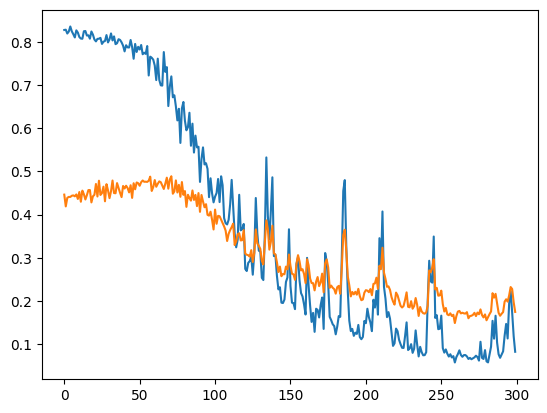

In [104]:
plt.plot(range(0,len(history_model.history["loss"])), history_model.history["loss"])
plt.plot(range(0,len(history_model.history["mean_absolute_error"])), history_model.history["mean_absolute_error"])

Попробуем предсказать какиенибудь значения

D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1000 [00:00<?, ?it/s]

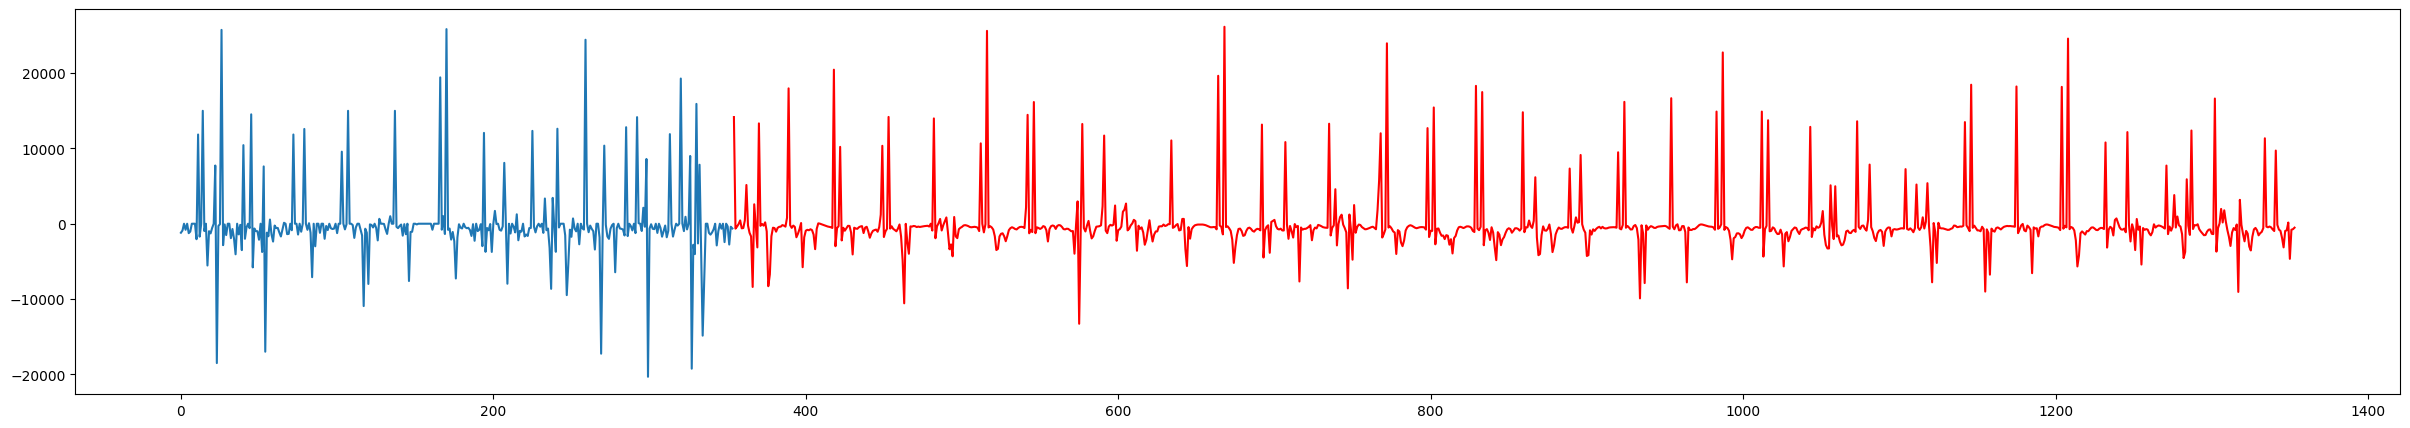

In [108]:
data_res = []
data_for_pred = data_inp[-N_day:]
for i in tqdm_notebook(range(1000)):
    data_pred = model.predict(data_for_pred.reshape(-1,N_day,1))
    data_for_pred = np.append(data_for_pred, data_pred)[-N_day:]
    data_res = np.append(data_res, data_pred)
plt.figure(figsize=(30,5))
plt.plot(range(len(data_inp)), scaler.inverse_transform(data_inp))    
plt.plot(range(len(data_inp),len(data_inp)+len(data_res)), scaler.inverse_transform(data_res.reshape(-1,1)), color="red")


Получился следующий результат, модель с использованием LSTM предсказывает с 70% вероятностью значения в следующего дня, для использования этой модели, ей необходимо передать 30 прошедших дня. По сравнению с предыдущими моделями она показывает наилучший результат, поэтому в дальнейшем будем использовать ее для расчета приблизительной даты окончания накопления средств.

In [109]:
model.save("PredictDifferenceBetwineIncomeOutcome.h5") # Сохранение модели

Методика предсказания приблизительной даты следующая, если разница между доходом и расходом полложительна, то в этот день пользователь положит деньги на счет согласно сумме разницы умноженной на процент вклада, то есть он будет класть не все деньги а только какойто процент. Например, 30% от суммы разницы. Однако если же сумма разницы отриательна то деньги не будут поступать на счет, ведь человеку нужно на что-то жить.

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def PredictDifferenceBetwineIncomeOutcomeLSTM(data : pd.DataFrame, res_summ : float = 0.0001, current_summ : float = 0, percent : float = 0.3):
    """       
        Нахождение приблизительной даты цели накопления средств при помощи модели PredictDifferenceBetwineIncomeOutcome
        на базе нейронной сети LSTM
        
        входные параметры:
         - data : pd.DataFrame - датафрейм (временной ряд) содержащий 30 строк и 2 колонки:
             - 1-я колонка "Доход"
             - 2-я колонка "Расход"
             - индексация по дате
         - res_summ : float = 0.0001 - цель накопления или сколько денег нужно накопить
         - current_summ : float = 0 - текущая сумма накопления
         - percent : float = 0.3 - процент который будет поступать с дохода на счет накопления
    """
    
    N_pred = 100 # количество дней которое нужно предсказать
    N_day = 30 # на сколько дней будет опираться модель

    input_data = np.array((data[data.columns[0]] - data[data.columns[1]])[-N_day:])
    
    if ((len(input_data)<N_day) or (percent<=0.001) or (percent>1.0)):
        print("Указано не достаточно входных данных, предсказание невозможно!")
        print(" - data должен содержать минимум 30 элементов в одном столбце")
        print(" - percent должен быть больше чем 0.001 и меньше 1")
        print(" - res_summ должен быть больше чем 0")
        print(" - current_summ должен быть больше или равен 0")
        return

    scaler_res = StandardScaler()
    input_data = scaler_res.fit_transform(input_data.reshape(-1,1))
    repeat = True
    model_res = keras.models.load_model("PredictDifferenceBetwineIncomeOutcome.h5")
    data_for_pred = input_data
    res_day = 0

    while(repeat):
        repeat = False
        data_res = []
        for i in range(N_pred):
            data_pred = model_res.predict(data_for_pred.reshape(-1,N_day,1))
            data_for_pred = np.append(data_for_pred, data_pred)[-N_day:]
            data_res = np.append(data_res, data_pred)

        data_for_pred = (data_res.reshape(-1,1))[-N_day:]
        data_res = scaler_res.inverse_transform(data_res.reshape(-1,1)).reshape(-1)

        count_day = 0
        for i in range(len(data_res)):
            if (data_res[i]>0):
                current_summ += data_res[i] * percent
                if (current_summ>=res_summ):
                    count_day = i
                    break
        if (count_day == 0):
            repeat = True
            res_day += i
        else:
            res_day += count_day
        if res_day > 14600:
            print("вам понадобится более 40 лет")
            print("текущая сумма на 40 годе: ", current_summ)
            return res_day, current_summ
            break
    
    count_day = res_day
    res_day = str(data.index[-1] + np.timedelta64(res_day,'D'))
    res_day = res_day[:res_day.find(" ")]
    print("Вы сможите достигнуть поставленной цели примерно : " + res_day)
    print("Примерная итоговая сумма накопления: ", current_summ)
    return count_day, current_summ

Проведем тест, на основе входных данных:
- data - данные доходов и расходов выше
- res_summ = 3000 - сумма до которой нужно накопить
- current_summ = 1000 - сколько лежит на данный момент 
- percent = 0.3 - процент который будет вкладывать пользователь на счет

In [110]:
res_summ = 300000 # сумма до которой нужно накопить
current_summ = 1000 # сколько лежит на данный момент 
percent = 0.3 # процент который будет вкладывать пользователь на счет

PredictDifferenceBetwineIncomeOutcomeLSTM(data, res_summ, current_summ, percent);

Вы сможите достигнуть поставленной цели примерно : 2026-05-16
Примерная итоговая сумма накопления:  300956.516557939
